In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from brica import Component, VirtualTimeScheduler, Timing

from matchernet.ekf import BundleEKFContinuousTime, MatcherEKF
from matchernet import fn
from matchernet.observer import Observer
from matchernet.state_space_model_2d import StateSpaceModel2Dim
from matchernet import utils
from matchernet.utils import print_flush

In [2]:
_with_brica = True

## Data

A two-dimensional state space model is simulated to generate data.

In [3]:
def prepare_data(dt, num_steps, num_observers):
    y_recs = []
    for i in range(num_observers):
        print_flush("Generating simulation sequences {}/{}".format(i, num_observers))
        sm = StateSpaceModel2Dim(
            n_dim=2,
            A=A0,
            g=fn.LinearFn(utils.zeros(2)),
            sigma_w=0.1,
            sigma_z=0.1,
            x=mu0[0],
            y=utils.zeros((1, 2))
        )
        sm.dt = dt
        (x_rec, y_rec) = sm.simulation(num_steps, dt)
        y_recs.append(y_rec)
    return y_recs

Randomly missing data and estimating the part.

In [4]:
def include_random_missing(y, num_steps):
    num_channels = len(y)
    for c in range(num_channels):
        y[c] = miss_hmm(y[c])
        plt.subplot(num_channels, 1, c + 1)
        for i in range(num_steps):
            if np.isnan(y[c][i, 0]):
                plt.plot([i, i], [-1, 1], '-', color='gray', linewidth='3')
        plt.plot(y[c], '.-')
    return y

In [5]:
def miss_hmm(y):
    num_steps, dim = y.shape
    n = 8
    r = np.convolve(np.random.rand(num_steps) - 0.5, np.ones(n), 'same')
    y[:, 0] = np.where(r > 0.5, y[:, 0], np.nan)
    y[:, 1] = np.where(r > 0.5, y[:, 1], np.nan)
    return y

## Model

Demonstrates the case where there are multiple observers.

In [6]:
def ekf_test_multiple_observer(dt, numSteps, num_observers, yrecs):
    """
    Run a matchernet of the following structure
    b0 --- m01 --- b1
       --- m02 --- b2
       --- m03 --- b3
    where b1, b2, and b3 are Observers
    """
    b0 = BundleEKFContinuousTime("b0", 2, fn.LinearFn(A0 * 0.5))
    b0.state.data["mu"] = mu0
    b0.state.data["Sigma"] = 2 * ey2
    b0.dt = dt
    b0.state.data["mu"][1] = 2

    bp = []
    for i in range(num_observers):
        bpname = "bp{}".format(i)
        bptmp = Observer(bpname, yrecs[i])
        bptmp.obs_noise_covariance = 5.0 * ey2
        bp.append(bptmp)

    # bp[0].obs_noise_covariance = 4*ey2
    # bp[1].obs_noise_covariance = 4*ey2

    mp = []
    for i in range(num_observers):
        mpname = "mp0{}".format(i)
        mptmp = MatcherEKF(mpname, b0, bp[i])
        mp.append(mptmp)

    s = VirtualTimeScheduler()

    bt = Timing(0, 1, 1)
    bm = Timing(1, 1, 1)

    s.add_component(b0.component, bt)
    for i in range(num_observers):
        s.add_component(bp[i].component, bt)
        s.add_component(mp[i].component, bm)

    for i in range(numSteps):
        print_flush("Step {}/{} with brica".format(i, numSteps))
        s.step()

## Experiment

Generating simulation sequences 4/5

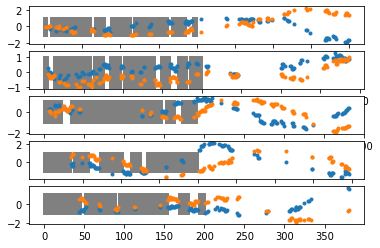

Step 199/200 with brica

<Figure size 432x288 with 0 Axes>

In [7]:
mu0 = np.array([0, 1.0], dtype=np.float32)
A0 = np.array([[-0.1, 2],[-2, -0.1]], dtype=np.float32)
ey2 = np.eye(2, dtype=np.float32)
dt = 0.02
num_steps = 200
num_observers = 5

y_recs = prepare_data(dt, num_steps, num_observers)
plt.figure(1)
y_recs = include_random_missing(y_recs, num_steps)
plt.pause(0.5)

plt.figure(2)
start = time.time()
ekf_test_multiple_observer(dt, num_steps, num_observers, y_recs)
elapsed_time = time.time() - start